In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

%matplotlib inline

# Polynomial Regression

In this lab, we'll explore how to generate the ${\tt Wage}$ dataset models we saw in class.

In [2]:
df = pd.read_csv('Wage.csv')
df.head(3)

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


We first fit the polynomial regression model using the following commands:

In [3]:
X1 = PolynomialFeatures(1).fit_transform(df.age.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.reshape(-1,1))

This syntax fits a linear model, using the ${\tt PolynomialFeatures()}$ function, in order to predict
wage using up to a fourth-degree polynomial in ${\tt age}$. The ${\tt PolynomialFeatures()}$ command
allows us to avoid having to write out a long formula with powers
of ${\tt age}$. We can then fit our linear model:

In [4]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,-184.1542,60.040,-3.067,0.002,-301.879 -66.430
x1,21.2455,5.887,3.609,0.000,9.703 32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968 -0.160
x3,0.0068,0.003,2.221,0.026,0.001 0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05 1.45e-07


Next we consider the task of predicting whether an individual earns more
than \$250,000 per year. We proceed much as before, except that first we
create the appropriate response vector, and then we fit a logistic model using the ${\tt GLM()}$ function from ${\tt statsmodels}$:

In [5]:
# Create response matrix
y = (df.wage > 250).map({False:0, True:1}).as_matrix()

# Fit logistic model
clf = sm.GLM(y, X4, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

We now create a grid of values for ${\tt age}$ at which we want predictions, and
then call the generic ${\tt predict()}$ function for each model:

In [6]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
pred1 = fit2.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

Finally, we plot the data and add the fit from the degree-4 polynomial.

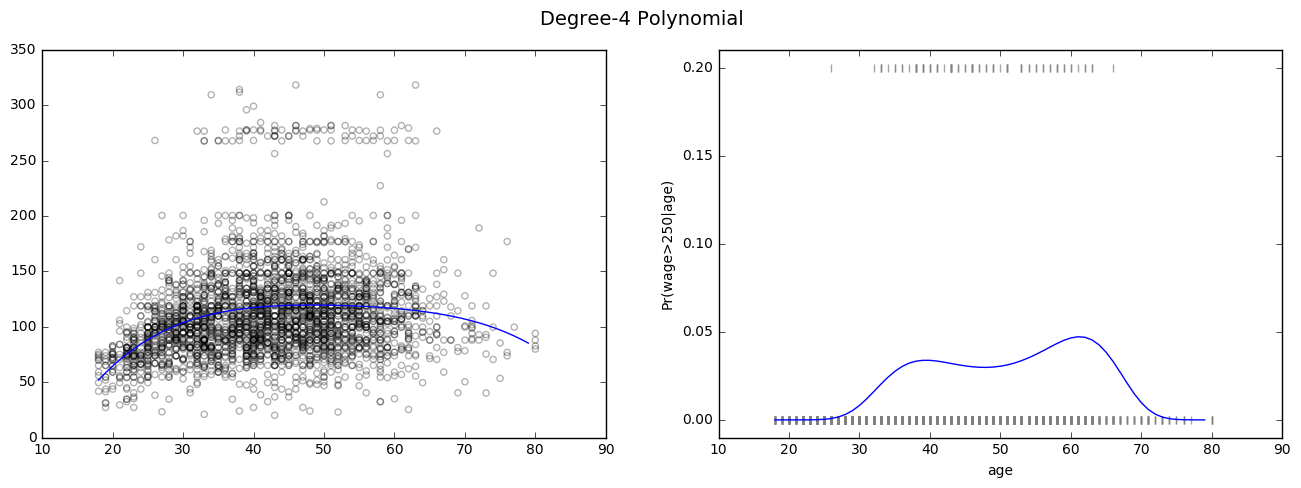

In [7]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred1, color = 'b')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

# Deciding on a degree

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis tests. We
now fit models ranging from linear to a degree-5 polynomial and seek to
determine the simplest model which is sufficient to explain the relationship
between ${\tt wage}$ and ${\tt age}$.

We can do this using the ${\tt anova\_lm()}$ function, which performs an
analysis of variance (ANOVA, using an F-test) in order to test the null
hypothesis that a model $M_1$ is sufficient to explain the data against the 
alternative hypothesis that a more complex model $M_2$ is required. In order
to use the ${\tt anova\_lm()}$ function, $M_1$ and $M_2$ must be **nested models**: the
predictors in $M_1$ must be a subset of the predictors in $M_2$. In this case,
we fit five different models and sequentially compare the simpler model to
the more complex model:

In [8]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

print(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


The $p$-value comparing the linear Model 1 to the quadratic Model 2 is
essentially zero $(<10^{-32})$, indicating that a linear fit is not sufficient. Similarly
the $p$-value comparing the quadratic Model 2 to the cubic Model 3
is very low (0.0017), so the quadratic fit is also insufficient. The $p$-value
comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately
0.05 while the degree-5 polynomial Model 5 seems unnecessary
because its $p$-value is 0.37. Hence, either a cubic or a quartic polynomial
appear to provide a reasonable fit to the data, but lower- or higher-order
models are not justified.

As an alternative to using hypothesis tests and ANOVA, we could choose
the polynomial degree using cross-validation as we have in previous labs.